In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pachner_traversal.utils import compute_rhat, data_path, set_style

set_style()

In [2]:
mcmc_result_path = data_path / "results" / "mcmc" / "generic_samples" / "20251004_1845"
assert mcmc_result_path.exists()

In [3]:
tet_map = {
    l: i for i, l in enumerate("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
}

In [4]:
metrics = [
    "agg_score_alex_norm",
    "agg_score_alex_deg",
    "agg_score_alex_det",
    "agg_score_edge_var",
    "agg_score_num_gen",
]

for metric in metrics:
    df = pd.read_csv(mcmc_result_path / f"{metric}_chains.csv", index_col=0)
    rhat, ess = compute_rhat(df)
    print(f"{metric:20} & {rhat:.3f} & {ess:,.0f} \\\\")

agg_score_alex_norm  & 1.003 & 69,540 \\
agg_score_alex_deg   & 1.004 & 69,500 \\
agg_score_alex_det   & 1.005 & 69,319 \\
agg_score_edge_var   & 1.006 & 69,131 \\
agg_score_num_gen    & 1.009 & 68,769 \\


In [14]:
def fit_alpha(all_data, x_min):
    data = all_data[all_data >= x_min]

    n = len(data)
    sum_log = np.sum(np.log(data / x_min))
    alpha = 1 + n / sum_log
    return alpha, (alpha - 1) * x_min ** (alpha - 1)


def get_area(bin_start, bin_end, alpha, C):
    return C * (bin_end ** (1 - alpha) - bin_start ** (1 - alpha)) / (1 - alpha)

def get_samps_exceed(alpha, x_min, threshold):
    return (threshold / x_min) ** (alpha-1)

In [23]:
def extract_data(tet_30_scores):
    data = tet_30_scores
    data = data[data > 0]

    x_min = data.min()
    sub_data = data[data >= x_min]

    alpha, C = fit_alpha(sub_data, x_min)
    C = C * len(sub_data) / len(data)

    min_val = np.min(data)
    max_val = np.max(data)
    log_bins = np.logspace(np.log10(min_val), np.log10(max_val), num=20)

    counts, bin_edges = np.histogram(data, bins=log_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1:] - bin_edges[:-1]
    counts = counts / (len(data) * bin_width)

    non_zero_indices = counts > 0
    x_values = bin_centers[non_zero_indices]
    y_values = counts[non_zero_indices]

    return data, C, alpha, counts, bin_edges

In [28]:
def generate_plot(data, C, alpha, counts, bin_edges, save_name):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(np.sort(np.r_[data]), C * np.sort(np.r_[data]) ** (-alpha), color="red", ls="--")

    true_area = 0

    for i in range(len(counts)):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i + 1]
        bin_height = counts[i]

        rect = patches.Rectangle(
            (bin_start, 0),
            bin_end - bin_start,
            bin_height,
            linewidth=0.5,
            edgecolor="black",
            facecolor="C0",
        )
        ax.add_patch(rect)


    scale = 1.1
    x_min = np.max(bin_edges) * (1 - scale) / 2 + np.min(bin_edges) * (1 + scale) / 2
    x_max = np.max(bin_edges) * (1 + scale) / 2 + np.min(bin_edges) * (1 - scale) / 2
    y_min = np.max(counts) * (1 - scale) / 2
    y_max = np.max(counts) * (1 + scale) / 2


    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(0, y_max)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Value")
    plt.ylabel("Density")
    # plt.axvline(reached_score, color="green", ls="--")
    plt.savefig(data_path.parent / 'thesis' / 'figures' / save_name, bbox_inches="tight")
    plt.show()

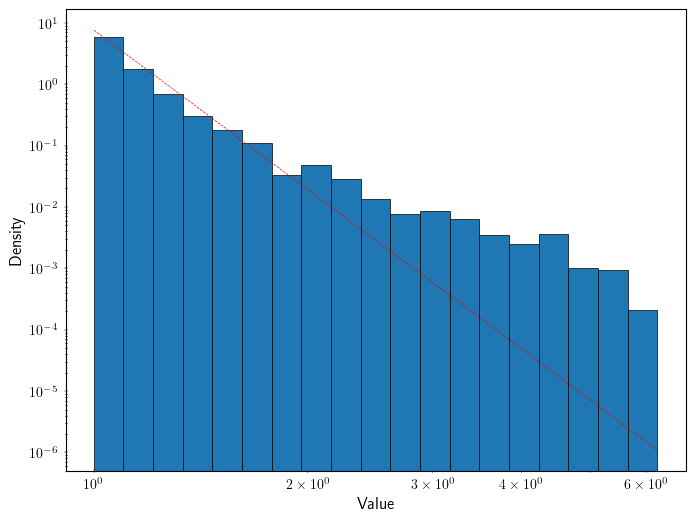

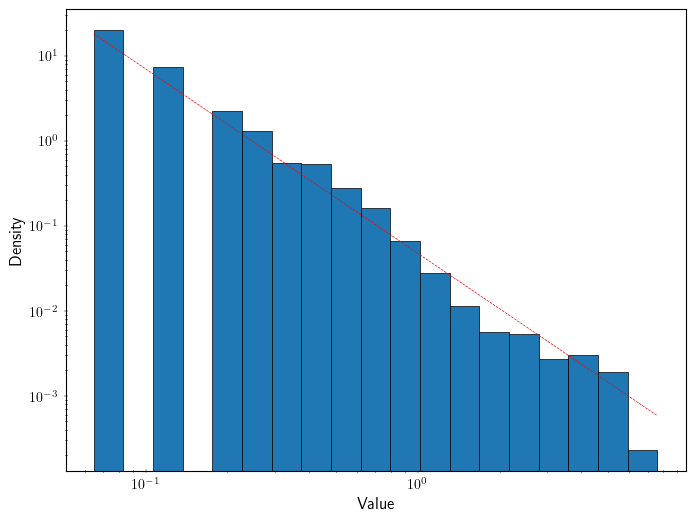

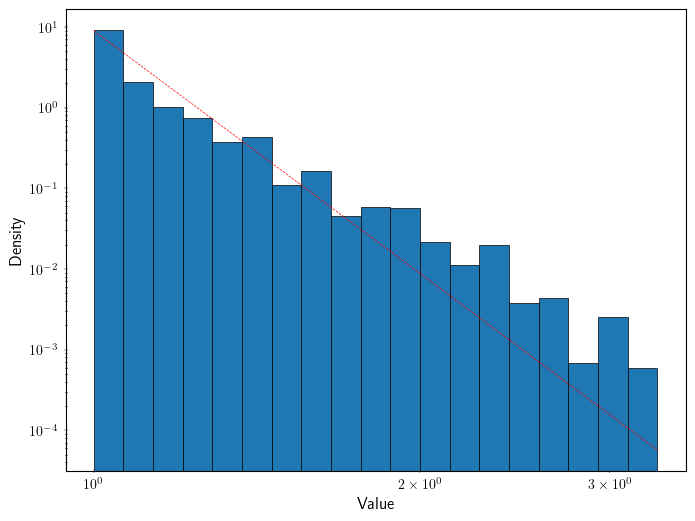

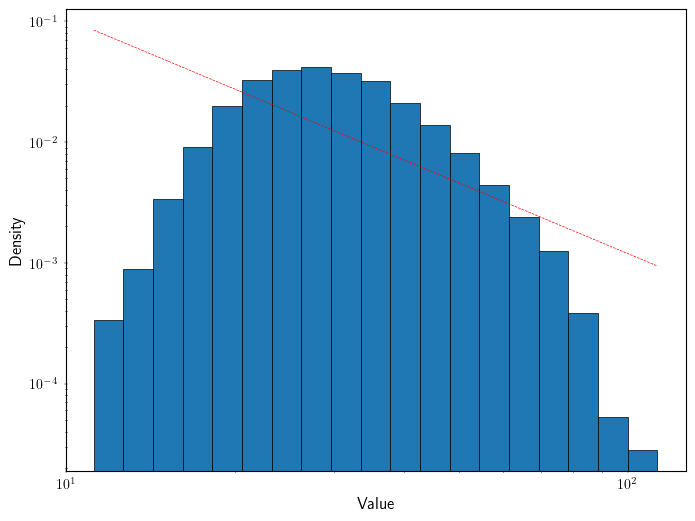

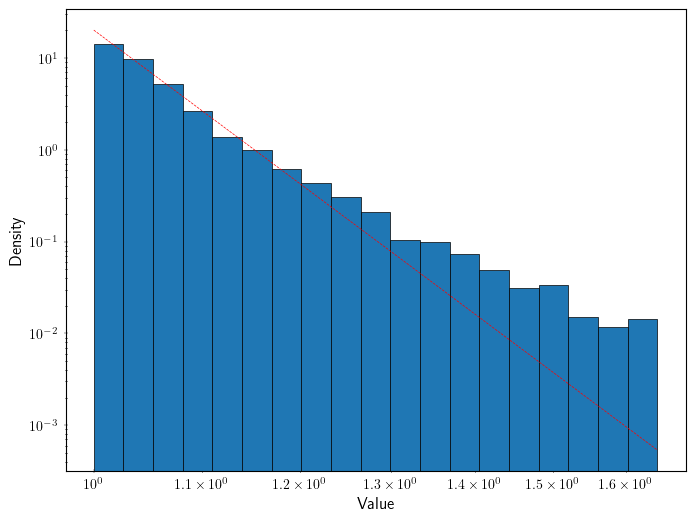

In [29]:
isos_df = pd.read_csv(mcmc_result_path / "isos_lists.csv")
tet_30_filter = isos_df.map(lambda x: x.startswith("E")).values.flatten()

for metric in metrics:
    score_df = pd.read_csv(mcmc_result_path / f"{metric}_chains.csv", index_col=0)
    tet_30_scores = score_df.values.flatten()[tet_30_filter]

    data, C, alpha, counts, bin_edges = extract_data(tet_30_scores)
    generate_plot(data, C, alpha, counts, bin_edges, f"{metric}_log_distribution.pdf")